In [163]:
import numpy as np
import pandas as pd
from datetime import date
from matplotlib import pyplot as plt

from numpy import cos, sin, arcsin, sqrt
from math import radians
import seaborn as sns

def haversine(row, lonlat):
    lat1, lon1 = lonlat
    lon2, lat2 = row['LNG'], row['LAT']
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * arcsin(sqrt(a)) 
    km = 6367 * c
    return km

def cell_from_coords(data, lonlat):
    data['LAT'], data['LNG'] = pd.to_numeric(data['LAT_Y'],errors='coerce'), pd.to_numeric(data['LONG_X'],errors='coerce')
    data['distance'] = data.apply(lambda row: haversine(row, lonlat), axis=1)
    row = data.sort_values(by='distance').iloc[0:1]
    data.drop(['distance', 'LAT', "LNG"], axis=1, inplace=True)
    return row

def normalize(data, column):
    data.loc[:, column] = (data[column]-data[column].mean())/data[column].std()
    return data

In [3]:
file_path = "/Users/filipkrasniqi/Documents/Datasets.tmp/traffic-covid/"
data = pd.read_pickle(file_path+'LTE_1800_Milano.pkl')

In [4]:
data.columns

Index(['REGIONE', 'COMUNE', 'LONG_X', 'LAT_Y', 'Date', 'ECELL_ID', 'DL_BW',
       'RRC_S_Succ', 'RRC_S_Att', 'RRC_S_SR', 'RRC_RE_Succ', 'RRC_RE_Att',
       'RRC_RE_SR', 'ERAB_S_Succ', 'ERAB_S_Att', 'ERAB_S_SR', 'CS_SR',
       'IntraF_Hout_Succ', 'IntraF_Hout_Att', 'IntraF_Hout_SR',
       'InterF_Hout_Succ', 'InterF_Hout_Att', 'InterF_Hout_SR', 'Hin_Succ',
       'Hin_Att', 'Hin_SR', 'InterR_HO_OUT_E2W_Succ', 'InterR_HO_OUT_E2W_Att',
       'InterR_HO_OUT_E2W_SR', 'InterR_HO_OUT_E2G_Succ',
       'InterR_HO_OUT_E2G_Att', 'InterR_HO_OUT_E2G_SR', 'DL_VOL', 'UL_VOL',
       'DL_THR_AVG', 'UL_THR_AVG', 'DL_THR_MAX', 'UL_THR_MAX', 'USERNUM_AVG',
       'USERNUM_MAX', 'PRB_DL_Used_Avg', 'PRB_UL_Used_Avg'],
      dtype='object')

In [5]:
data_800 = pd.read_pickle(file_path+'LTE_800_Milano.pkl')
max(data_800["Date"])

Timestamp('2020-03-30 23:00:00')

In [6]:
# TODO vedere come cambia il traffico in un orario come le 8 del mattino (si va al lavoro) nel periodo febbraio - marzo (ingresso in lockdown)
# TODO si potrebbe utilizzare questa informazione???
porta_garibaldi_coords = 45.4802661, 9.1828309
cell = cell_from_coords(data, porta_garibaldi_coords)
pg_cell_id = cell["ECELL_ID"].item()

In [7]:
dl_data = data[["ECELL_ID", "DL_VOL", "Date", "USERNUM_AVG", "Hin_Succ"]]
pg_data = dl_data.where(dl_data["ECELL_ID"] == pg_cell_id).dropna()
pg_data = pg_data[pg_data['Date'] > pd.Timestamp(year=2020, month=2, day=1, hour = 0, minute =1)]
pg_data = pg_data[pg_data['Date'] < pd.Timestamp(year=2020, month=4, day=1, hour = 0, minute =1)]
pg_data = pg_data.set_index('Date')

hour_8_data_pg = pg_data.between_time('07:30:00', '08:30:00')

hour_8_data_pg.loc[:, "DL_VOL_MEAN"] = hour_8_data_pg["DL_VOL"].rolling(5).mean()
hour_8_data_pg.loc[:, "US_NUM_MEAN"] = hour_8_data_pg["USERNUM_AVG"].rolling(5).mean()
hour_8_data_pg.loc[:, "HIN_SUC_MEAN"] = hour_8_data_pg["Hin_Succ"].rolling(5).mean()

hour_8_data_pg.dropna(inplace=True)
hour_8_data_pg = normalize(hour_8_data_pg, "DL_VOL_MEAN")
hour_8_data_pg = normalize(hour_8_data_pg, "US_NUM_MEAN")
hour_8_data_pg = normalize(hour_8_data_pg, "HIN_SUC_MEAN")
hour_8_data_pg.head()

/Users/filipkrasniqi/.local/share/virtualenvs/traffic-covid-andFrCfE/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/filipkrasniqi/.local/share/virtualenvs/traffic-covid-andFrCfE/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-7-bf4fe883aa46>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of

,ECELL_ID,DL_VOL,USERNUM_AVG,Hin_Succ,DL_VOL_MEAN,US_NUM_MEAN,HIN_SUC_MEAN
Date,,,,,,,
2020-02-05 08:00:00,b7d36179e57ba83,70668848.0,54.3714,1516.0,0.128644,0.028591,0.746454
2020-02-06 08:00:00,b7d36179e57ba83,59375696.0,53.8667,1412.0,0.803000,0.792889,1.269503
2020-02-07 08:00:00,b7d36179e57ba83,56340096.0,49.0936,1312.0,1.343849,1.426277,1.799871
2020-02-08 08:00:00,b7d36179e57ba83,53514856.0,35.9647,395.0,1.718148,1.034088,1.256329
2020-02-09 08:00:00,b7d36179e57ba83,30168264.0,34.5058,262.0,1.116838,0.725028,0.734744


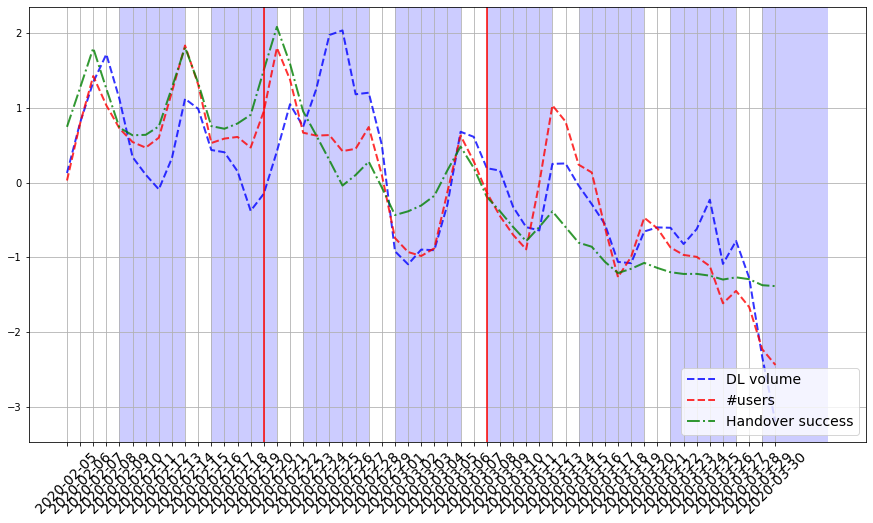

In [8]:
fig, ax = plt.subplots(figsize=(15,8))

# https://ytali.com/2020/04/23/covid-19-la-lezione-della-notte-del-21-febbraio-2020/
# lockdown: 09/03
idx_feb = [i for i, date in enumerate(hour_8_data_pg.index) if date.month == 2 and date.day == 21][0]
idx_lockdown = [i for i, date in enumerate(hour_8_data_pg.index) if date.month == 3 and date.day == 9][0]


# plot data
ax.plot(list(range(1,len(hour_8_data_pg)+1)),hour_8_data_pg['DL_VOL_MEAN'], linestyle='--', lw=2, color='b',label='DL volume', alpha=.8) 
ax.plot(list(range(1,len(hour_8_data_pg)+1)),hour_8_data_pg['US_NUM_MEAN'], linestyle='--', lw=2, color='r',label='#users', alpha=.8) 
ax.plot(list(range(1,len(hour_8_data_pg)+1)),hour_8_data_pg['HIN_SUC_MEAN'], linestyle='-.', lw=2, color='g',label='Handover success', alpha=.8) 
# ax.plot(list(range(1,len(daily_stat)+1)),daily_stat['Median'], linestyle='--', lw=2, color='r',label='Median Trace', alpha=.8) 

# Set plotting option
plt.xticks(color='black')
plt.yticks(color='black')
plt.grid(1)
plt.xticks(ticks = range(1,len(hour_8_data_pg)+1) ,labels = list(hour_8_data_pg.index.date), fontsize = 14, rotation=45)
plt.axvline(idx_lockdown, color='r')
plt.axvline(idx_feb, color='r')

mondays = [i for i, date in enumerate(hour_8_data_pg.index) if date.dayofweek == 0]
for monday in mondays:
    plt.axvspan(monday, monday+5, facecolor='b', alpha=0.2)
# plt.xlabel('Day of 2nd Week', color='black', fontsize=14)
# plt.ylabel('Bits', color='black', fontsize=14)
plt.legend(loc="lower right", fontsize=14)
# plt.title('Median Daily/Night Traces of '+ref_KPI+' - Cell_id:%s'%cell_id, fontsize=14)
plt.show()

In [166]:
duomo = 45.4641013,9.1897378
cell = cell_from_coords(data, duomo)
duomo_cell_id = cell["ECELL_ID"].item()

duomo_data = dl_data.where(dl_data["ECELL_ID"] == duomo_cell_id).dropna()
duomo_data = duomo_data[duomo_data['Date'] > pd.Timestamp(year=2020, month=1, day=20, hour = 0, minute =1)]
duomo_data = duomo_data[duomo_data['Date'] < pd.Timestamp(year=2020, month=4, day=1, hour = 0, minute =1)]
duomo_data = duomo_data.set_index('Date')

hour_8_data_duomo = duomo_data.between_time('07:30:00', '08:30:00')

hour_8_data_duomo.loc[:, "DL_VOL_MEAN"] = hour_8_data_duomo["DL_VOL"].rolling(2).mean()
hour_8_data_duomo.loc[:, "US_NUM_MEAN"] = hour_8_data_duomo["USERNUM_AVG"].rolling(2).mean()
hour_8_data_duomo.loc[:, "HIN_SUC_MEAN"] = hour_8_data_duomo["Hin_Succ"].rolling(2).mean()

hour_8_data_duomo.dropna(inplace=True)
hour_8_data_duomo = normalize(hour_8_data_duomo, "DL_VOL_MEAN")
hour_8_data_duomo = normalize(hour_8_data_duomo, "US_NUM_MEAN")
hour_8_data_duomo = normalize(hour_8_data_duomo, "HIN_SUC_MEAN")
hour_8_data_duomo.head()

/Users/filipkrasniqi/.local/share/virtualenvs/traffic-covid-andFrCfE/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/filipkrasniqi/.local/share/virtualenvs/traffic-covid-andFrCfE/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-166-67dbbb493dd6>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy 

,ECELL_ID,DL_VOL,USERNUM_AVG,Hin_Succ,DL_VOL_MEAN,US_NUM_MEAN,HIN_SUC_MEAN
Date,,,,,,,
2020-02-02 08:00:00,fb8dfbdff567720,7812496.0,6.32944,166.0,-0.080977,-0.424173,-0.771766
2020-02-03 08:00:00,fb8dfbdff567720,12938648.0,16.3331,946.0,0.071859,0.137336,0.119773
2020-02-04 08:00:00,fb8dfbdff567720,18140720.0,19.3014,1011.0,0.644443,0.898872,1.099422
2020-02-05 08:00:00,fb8dfbdff567720,22648088.0,22.3433,1142.0,1.182723,1.251713,1.326655
2020-02-06 08:00:00,fb8dfbdff567720,21225440.0,23.3708,1079.0,1.353736,1.490615,1.405490


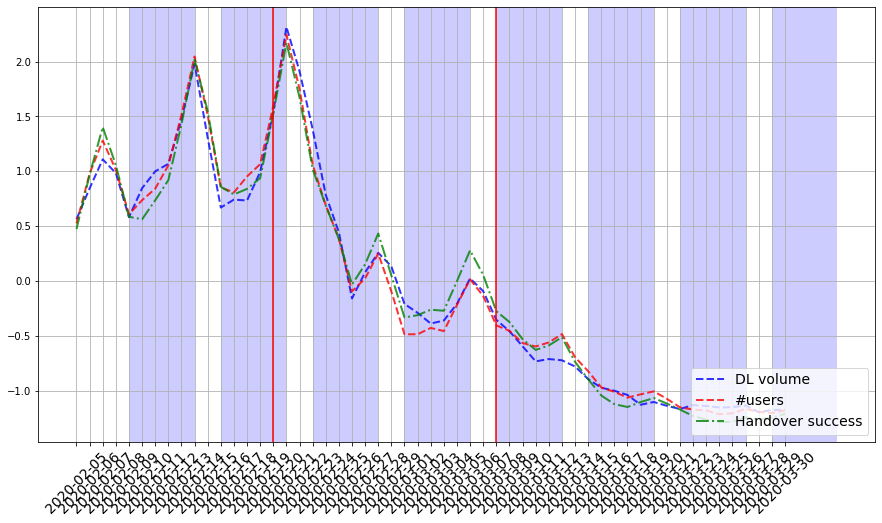

In [10]:
fig, ax = plt.subplots(figsize=(15,8))


# plot data
ax.plot(list(range(1,len(hour_8_data_duomo)+1)),hour_8_data_duomo['DL_VOL_MEAN'], linestyle='--', lw=2, color='b',label='DL volume', alpha=.8) 
ax.plot(list(range(1,len(hour_8_data_duomo)+1)),hour_8_data_duomo['US_NUM_MEAN'], linestyle='--', lw=2, color='r',label='#users', alpha=.8) 
ax.plot(list(range(1,len(hour_8_data_duomo)+1)),hour_8_data_duomo['HIN_SUC_MEAN'], linestyle='-.', lw=2, color='g',label='Handover success', alpha=.8) 
# ax.plot(list(range(1,len(daily_stat)+1)),daily_stat['Median'], linestyle='--', lw=2, color='r',label='Median Trace', alpha=.8) 

# Set plotting option
plt.xticks(color='black')
plt.yticks(color='black')
plt.grid(1)
plt.xticks(ticks = range(1,len(hour_8_data_duomo)+1) ,labels = list(hour_8_data_duomo.index.date), fontsize = 14, rotation=45)
plt.axvline(idx_lockdown, color='r')
plt.axvline(idx_feb, color='r')

mondays = [i for i, date in enumerate(hour_8_data_duomo.index) if date.dayofweek == 0]
for monday in mondays:
    plt.axvspan(monday, monday+5, facecolor='b', alpha=0.2)
# plt.xlabel('Day of 2nd Week', color='black', fontsize=14)
# plt.ylabel('Bits', color='black', fontsize=14)
plt.legend(loc="lower right", fontsize=14)
# plt.title('Median Daily/Night Traces of '+ref_KPI+' - Cell_id:%s'%cell_id, fontsize=14)
plt.show()

In [11]:
# TODO analizzare le feature
# TODO pensare ad una rappresentazione in mappa
# 1) show differences between february and march in map: avg for each cell the value per week and you represent a square with hue that has the handover and the dl_vol. Second should be informative regarding the heaviness of the applications of the applications.
# 2) 
import geopandas

In [12]:
# TODO plot in map: just plot a point for each coordinate
coordinates = data.drop_duplicates("ECELL_ID",keep= 'last')

<ipython-input-16-3e435ddf624d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coordinates['LAT'], coordinates['LNG'] = pd.to_numeric(coordinates['LAT_Y'],errors='coerce'), pd.to_numeric(coordinates['LONG_X'],errors='coerce')


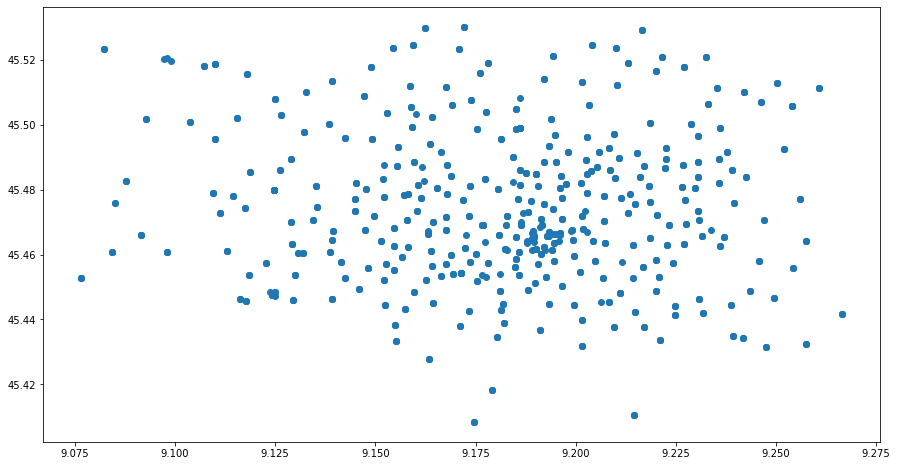

In [16]:
fig, ax = plt.subplots(figsize=(15,8))
coordinates['LAT'], coordinates['LNG'] = pd.to_numeric(coordinates['LAT_Y'],errors='coerce'), pd.to_numeric(coordinates['LONG_X'],errors='coerce')
x, y = coordinates["LNG"].values, coordinates["LAT"].values

plt.scatter(x, y)  # plot x and y using blue circle markers)
plt.show()

In [35]:
def plot_map(data, col, month):
    data_february = data[data['Date'] > pd.Timestamp(year=2020, month=month, day=1, hour = 0, minute =1)]
    data_february = data_february[data_february['Date'] < pd.Timestamp(year=2020, month=month+1, day=1, hour = 0, minute =1)]
    data_february['LAT'], data_february['LNG'] = pd.to_numeric(data_february['LAT_Y'],errors='coerce'), pd.to_numeric(data_february['LONG_X'],errors='coerce')
    data_groupped_february = data_february.groupby('ECELL_ID').mean()

    fig, ax = plt.subplots(figsize=(15,8))
    sns.scatterplot(data=data_groupped_february, x="LNG", y="LAT", hue=col, size=col, sizes=(20, 200))

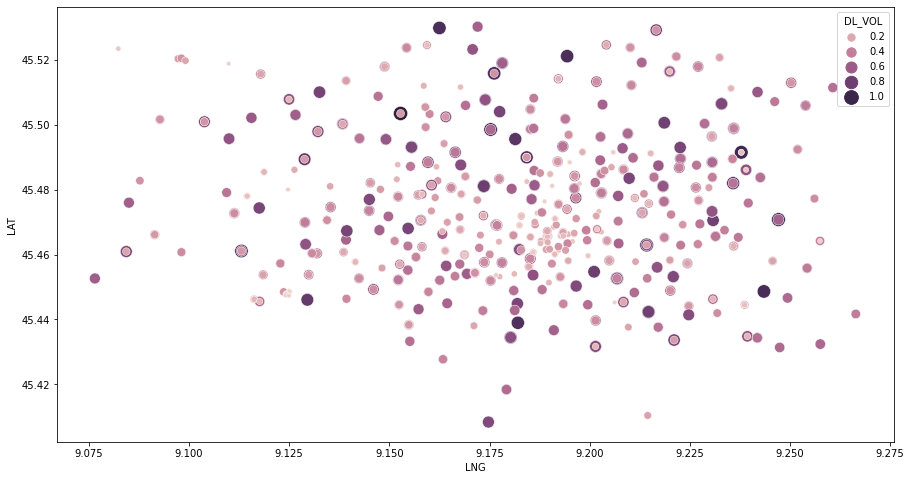

In [36]:
plot_map(data, "DL_VOL", 2)

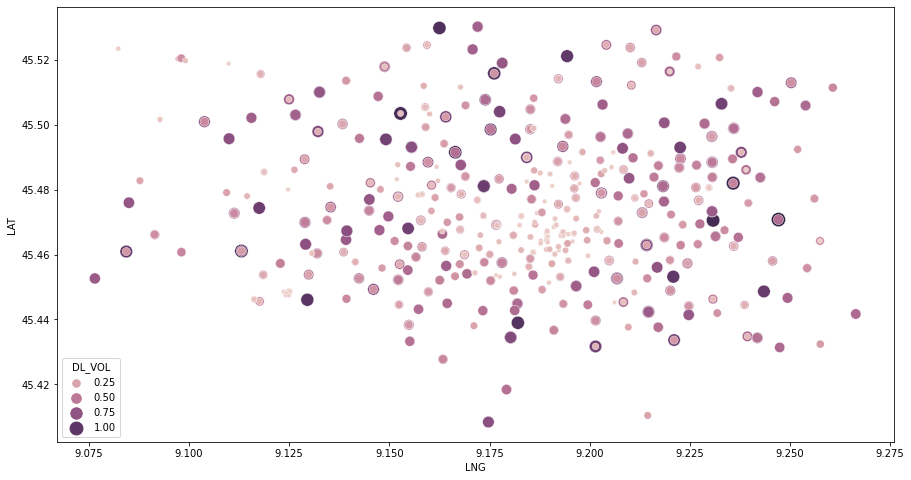

In [37]:
plot_map(data, "DL_VOL", 3)

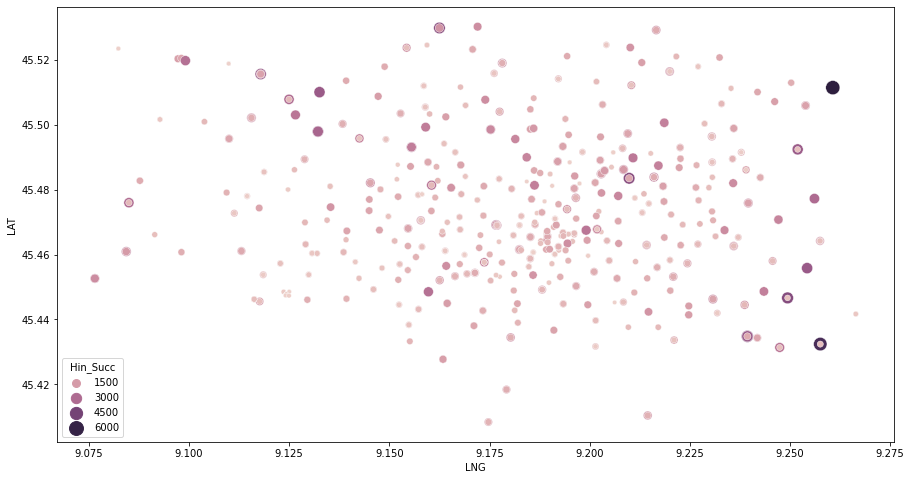

In [42]:
plot_map(data, "Hin_Succ", 2)

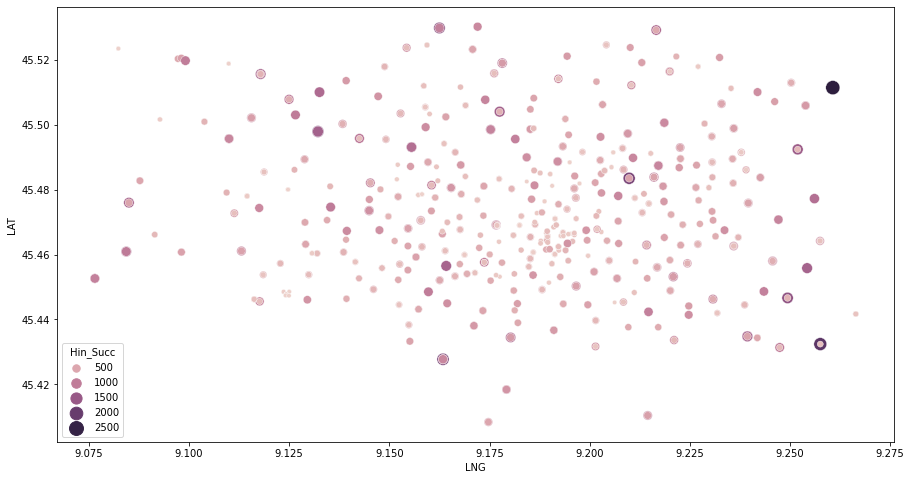

In [43]:
plot_map(data, "Hin_Succ", 3)

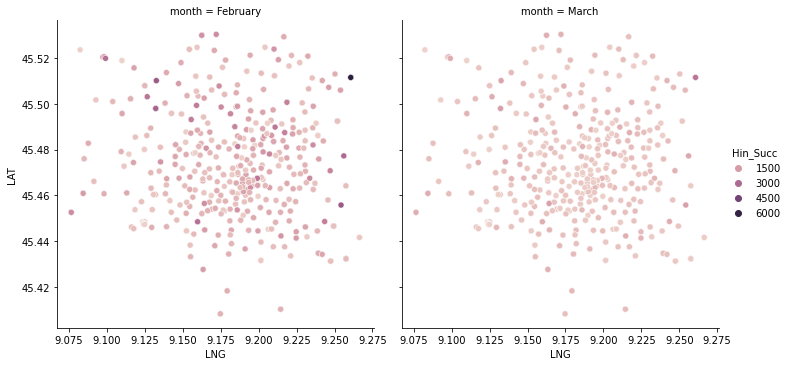

In [46]:
col,month="Hin_Succ",2
data_february = data[data['Date'] > pd.Timestamp(year=2020, month=month, day=1, hour = 0, minute =1)]
data_february = data_february[data_february['Date'] < pd.Timestamp(year=2020, month=month+1, day=1, hour = 0, minute =1)]
data_february['LAT'], data_february['LNG'] = pd.to_numeric(data_february['LAT_Y'],errors='coerce'), pd.to_numeric(data_february['LONG_X'],errors='coerce')
data_groupped_february = data_february.groupby('ECELL_ID').mean()

data_groupped_february["month"] = "February"

col,month="Hin_Succ",3
data_march = data[data['Date'] > pd.Timestamp(year=2020, month=3, day=1, hour = 0, minute =1)]
data_march = data_march[data_march['Date'] < pd.Timestamp(year=2020, month=month+1, day=1, hour = 0, minute =1)]
data_march['LAT'], data_march['LNG'] = pd.to_numeric(data_march['LAT_Y'],errors='coerce'), pd.to_numeric(data_march['LONG_X'],errors='coerce')
data_groupped_march = data_march.groupby('ECELL_ID').mean()

data_groupped_march["month"] = "March"

data_groupped = pd.concat([data_groupped_february, data_groupped_march])

sns.relplot(
    data=data_groupped, x="LNG", y="LAT",
    col="month", hue="Hin_Succ",
    kind="scatter"
)

In [47]:
# TODO mostrare per ogni mese, fissata la cella, l'evoluzione come mostrata qui
data_2 = pd.read_pickle(file_path+'LTE_1800_Milano_p2.pkl')
all_data = pd.concat([data, data_2])
all_data["month"] = all_data['Date'].dt.strftime("%m/%y")
all_data['LAT'], all_data['LNG'] = pd.to_numeric(all_data['LAT_Y'],errors='coerce'), pd.to_numeric(all_data['LONG_X'],errors='coerce')
data_groupped_month_cell = all_data.groupby(['ECELL_ID', 'month']).mean()

# keeping info about month
all_months = all_data["month"].unique()
data_groupped_month_cell['month'] = [month for (cell, month) in data_groupped_month_cell.index]

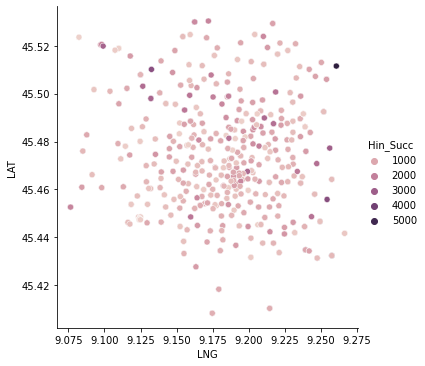

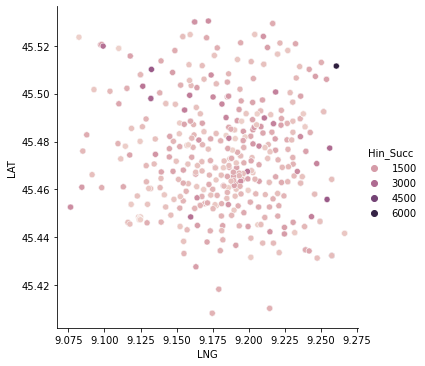

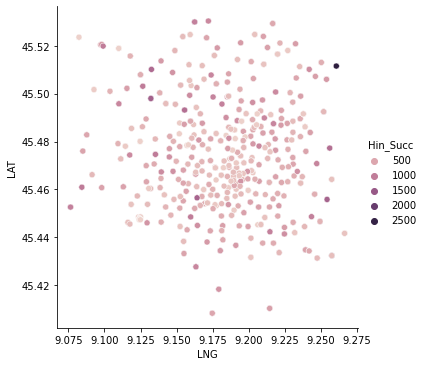

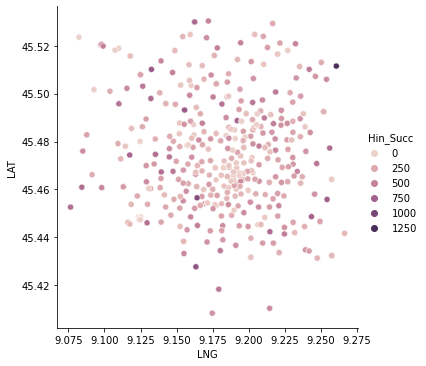

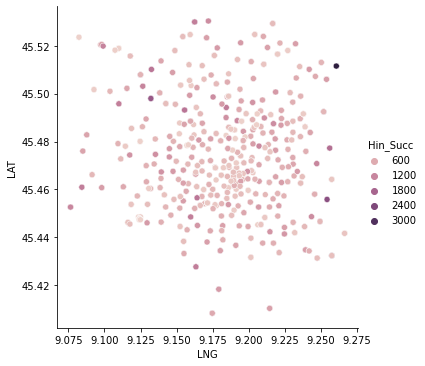

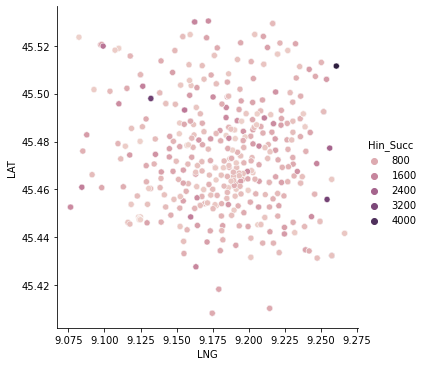

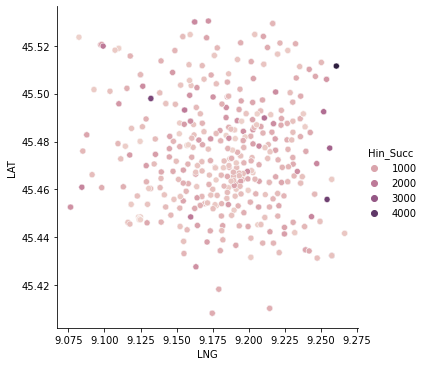

In [128]:
for current_month in all_months:
    current_idxs = [(cell, current_month) for cell in all_cells]# [i for i, (cell, month) in enumerate(data_groupped_month_cell.index) if month == current_month]
    # print(current_idxs)
    current_data = data_groupped_month_cell[data_groupped_month_cell['month'] == current_month]
    sns.relplot(
        data=current_data, x="LNG", y="LAT",
        hue="Hin_Succ",
        kind="scatter"
    )

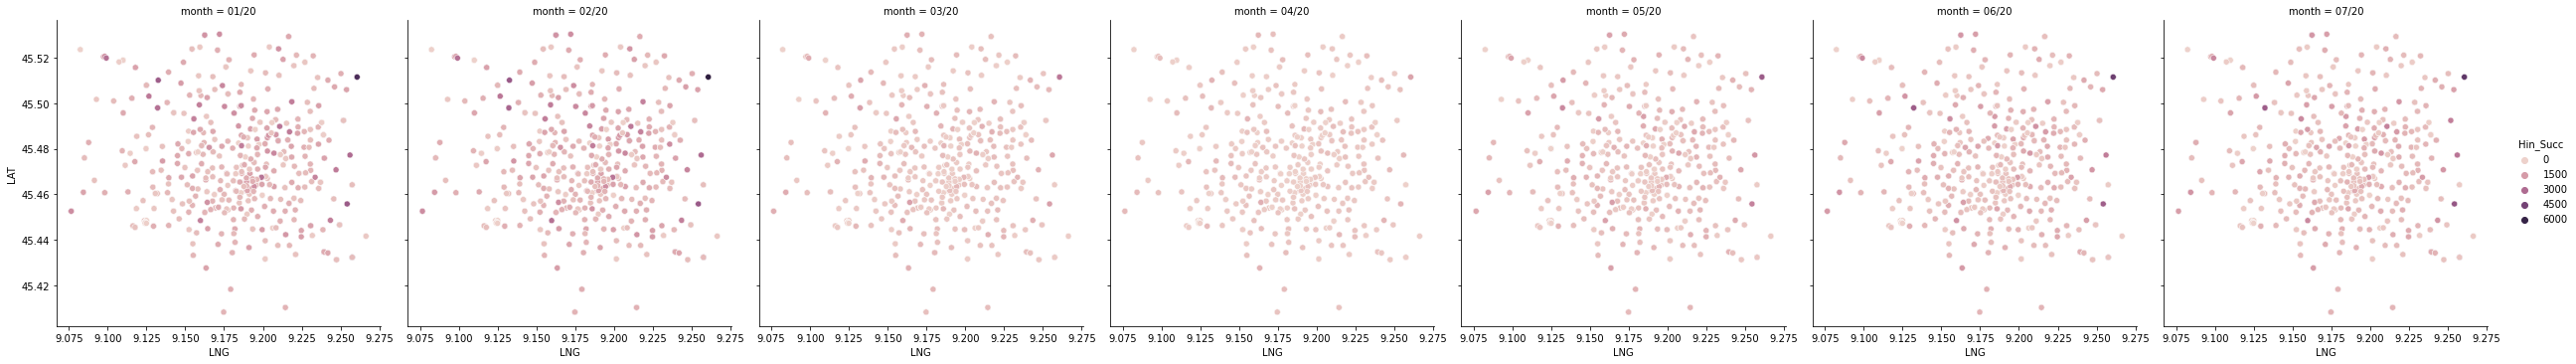

In [72]:
sns.relplot(
    data=data_groupped_month_cell, x="LNG", y="LAT",
    col="month", hue="Hin_Succ",
    kind="scatter"
)

In [134]:
def get_data_cell(all_dl_data, cell_id):
    filtered_data = all_dl_data.where(all_dl_data["ECELL_ID"] == cell_id).dropna()
    # all_duomo_data = all_duomo_data[all_duomo_data['Date'] > pd.Timestamp(year=2020, month=1, day=20, hour = 0, minute =1)]
    # all_duomo_data = all_duomo_data[all_duomo_data['Date'] < pd.Timestamp(year=2020, month=8, day=1, hour = 0, minute =1)]
    filtered_data = filtered_data.set_index('Date')

    filtered_data = filtered_data.between_time('07:30:00', '08:30:00')
    filtered_data.loc[:, "DL_VOL_MEAN"] = filtered_data["DL_VOL"].rolling(5).mean()
    filtered_data.loc[:, "US_NUM_MEAN"] = filtered_data["USERNUM_AVG"].rolling(5).mean()
    filtered_data.loc[:, "HIN_SUC_MEAN"] = filtered_data["Hin_Succ"].rolling(5).mean()

    filtered_data.dropna(inplace=True)
    filtered_data = normalize(filtered_data, "DL_VOL_MEAN")
    filtered_data = normalize(filtered_data, "US_NUM_MEAN")
    filtered_data = normalize(filtered_data, "HIN_SUC_MEAN")
    
    return filtered_data

def plot_mean_timeseries(data):
    fig, ax = plt.subplots(figsize=(15,8))

    # plot data
    ax.plot(list(range(1,len(data)+1)),data['DL_VOL_MEAN'], linestyle='--', lw=2, color='b',label='DL volume', alpha=.8) 
    ax.plot(list(range(1,len(data)+1)),data['US_NUM_MEAN'], linestyle='--', lw=2, color='r',label='#users', alpha=.8) 
    ax.plot(list(range(1,len(data)+1)),data['HIN_SUC_MEAN'], linestyle='-.', lw=2, color='g',label='Handover success', alpha=.8) 
    # ax.plot(list(range(1,len(daily_stat)+1)),daily_stat['Median'], linestyle='--', lw=2, color='r',label='Median Trace', alpha=.8) 

    # Set plotting option
    plt.xticks(color='black')
    plt.yticks(color='black')
    plt.grid(1)
    plt.xticks(ticks = range(1,len(data)+1) ,labels = list(data.index.date), fontsize = 14, rotation=45)
    plt.axvline(idx_lockdown, color='r')
    plt.axvline(idx_feb, color='r')

    mondays = [i for i, date in enumerate(data.index) if date.dayofweek == 0]
    for monday in mondays:
        plt.axvspan(monday, monday+5, facecolor='b', alpha=0.2)
    # plt.xlabel('Day of 2nd Week', color='black', fontsize=14)
    # plt.ylabel('Bits', color='black', fontsize=14)
    plt.legend(loc="lower right", fontsize=14)
    # plt.title('Median Daily/Night Traces of '+ref_KPI+' - Cell_id:%s'%cell_id, fontsize=14)
    plt.show()

In [132]:
all_dl_data = all_data[["ECELL_ID", "DL_VOL", "Date", "USERNUM_AVG", "Hin_Succ"]]

In [137]:
all_hour_8_data_duomo = get_data_cell(all_dl_data, duomo_cell_id)

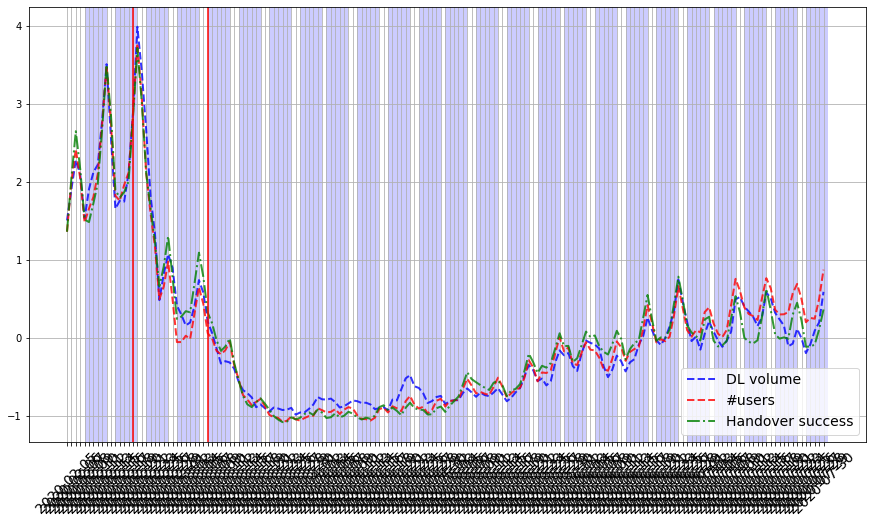

In [135]:
plot_mean_timeseries(all_hour_8_data_duomo)

In [139]:
all_hour_8_data_pg = get_data_cell(all_dl_data, pg_cell_id)

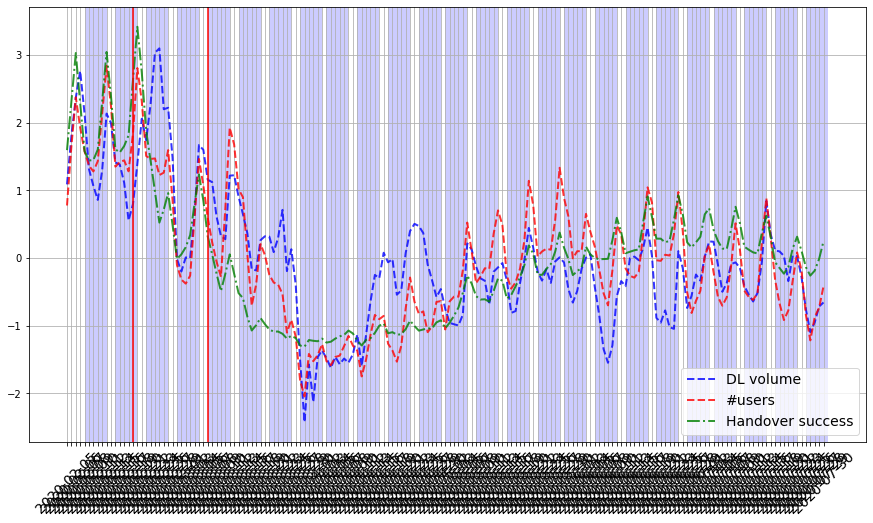

In [141]:
plot_mean_timeseries(all_hour_8_data_pg)

In [164]:
# TODO fornisci in input 5 posti diversi e mostra l'evoluzione di handover
def plot_mean_timeseries_places(data, places):
    fig, ax = plt.subplots(figsize=(15,8))
    
    # TODO filter by places
    data_filtered = pd.DataFrame()
    for place in places:
        name, cell = place
        current_data = data.where(data["ECELL_ID"] == cell).dropna()
        current_data["place"] = name
        data_filtered = pd.concat([data_filtered, current_data])
    
    data_filtered = normalize(data_filtered, "DL_VOL")
        
    sns.lineplot(data=data_filtered, x="Date", y="DL_VOL", hue="place")#, style="event")
    
    '''
    mondays = [i for i, date in enumerate(data_filtered["Date"]) if date.dayofweek == 0]
    for monday in mondays:
        monday.year = 2020
        plt.axvspan(monday, monday+5, facecolor='b', alpha=0.2)

    # TODO capire bene cosa mostrare, non mi piace che lundì - martdì venga influenzato da sabato-domenica. Farei rolling mean a 2g
    
    # https://ytali.com/2020/04/23/covid-19-la-lezione-della-notte-del-21-febbraio-2020/
    idx_feb = [i for i, date in enumerate(data_filtered["Date"]) if date.month == 2 and date.day == 21 and date.year == 2020][0]
    # lockdown: 09/03
    idx_lockdown = [i for i, date in enumerate(data_filtered["Date"]) if date.month == 3 and date.day == 9 and date.year == 2020][0]
    # chiusura per corridori
    idx_runner = [i for i, date in enumerate(data_filtered["Date"]) if date.month == 3 and date.day == 20 and date.year == 2020][0]
    # chiusura comuni
    idx_comune = [i for i, date in enumerate(data_filtered["Date"]) if date.month == 3 and date.day == 22 and date.year == 2020][0]
    # apertura di negozi per bambini e altro
    idx_shops = [i for i, date in enumerate(data_filtered["Date"]) if date.month == 4 and date.day == 14 and date.year == 2020][0]
    # fine fase 1
    idx_fase2 = [i for i, date in enumerate(data_filtered["Date"]) if date.month == 5 and date.day == 4 and date.year == 2020][0]
    # Plotting vertical lines
    idxs = [idx_feb, idx_lockdown, idx_runner, idx_comune, idx_shops, idx_fase2]
    
    for idx in idxs:
        plt.axvline(idx, color='r')
    '''

In [161]:
places = [("P. Garibaldi", pg_cell_id), ("Duomo", duomo_cell_id)]

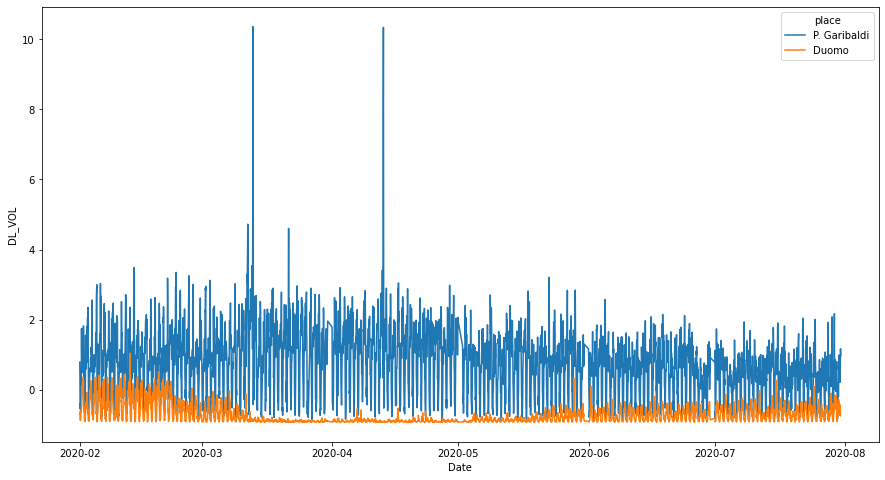

In [165]:
plot_mean_timeseries_places(all_dl_data, places)

In [ ]:
# TODO not only h8
# TODO weekly timeseries
# -> see results on antlab by Franci

In [ ]:
# TODO 
# spatial distribution: correlation between two lockdown, same among different cities, more cities, autocorrelation per city
# time distribution: timeseries per day in Milan, timeseries per day in COVID (infection), correlation between the two (also in different values of k, being k the possible lags), then more cities, then more COVID features (not only infections, also deaths, people in TI); it would be interesting to add also autocorrelation information
# Giovedì 10/12 